(counts_prediction_notebook)=
# La predizione delle frequenze 

Nella ricerca sul trauma, come in altri campi di ricerca, il risultato di interesse può essere rappresentato dalla frequenza del numero di episodi che si verificano in un dato periodo di tempo. Nel caso della ricerca sulla violenza domestica, ad esempio, potremmo esaminare il tasso di atti aggressivi durante l'intervallo tra un momento temporale di baseline e un'intervista di follow-up. Altri esempi di risultati esprimibili in termini di frequenze nalla ricerca post-traumatica includono la frequenza dell'abuso di sostanze durante un periodo di osservazione o il numero di interventi della polizia durante un dato periodo.

In questo capitolo esamineremo l'uso della predizione bayesiana per predire il numero di aggressioni nei confronti del partner nelle relazioni di coppia. I dati presentati sono tratti da uno studio che esamina la frequenza di episodi di aggressione messi in atto da pazienti di sesso maschile che avevano recentemente iniziato un programma di trattamento dell'alcol nei confronti del loro partner di sesso femminile.

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import statistics
import arviz as az
import seaborn as sns
import scipy.stats as st 
import pymc as pm
import xarray as xr
from scipy.constants import golden
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [34]:
%matplotlib inline
plt.rc('figure', figsize=(5.0, 5.0/golden))
sns.set_theme()
sns.set_palette("colorblind")
SEED = 42
rng = np.random.default_rng(SEED)

La frequenza degli episodi di violenza, così come altri fenomeni quantificabili in termini di frequenze assolute, può essere modellata da un processo di Poisson, che si basa sul presupposto che gli eventi siano casuali e abbiano la stessa probabilità di verificarsi in qualsiasi momento. Naturalmente, questa ipotesi non è sempre valida, ma spesso è sufficiente per la modellazione.

## La distribuzione a priori

In una ricerca sui pazienti che avevano recentemente iniziato un programma di trattamento per l'abuso o la dipendenza da alcol, {cite:t}`gagnon2008poisson` hanno trovato che, in un periodo di 6 mesi, il numero di assalti fisici da parte dei pazienti di genere maschile nei confronti dei loro partner femminili è uguale, in media, a 11.46 ($SD$ = 25.79; $n$ = 114). Per questi dati, la distribuzione del numero di episodi di aggressione fisica può, approssimativamente, essere rappresentata dalla seguente distribuzione esponenziale. Considereremo questa la  distribuzione a priori relativa alle nostre credenze circa la frequenza media $\mu$ degli episodi di aggressione nei confronti del partner per questa popolazione, in un periodo di 6 mesi.

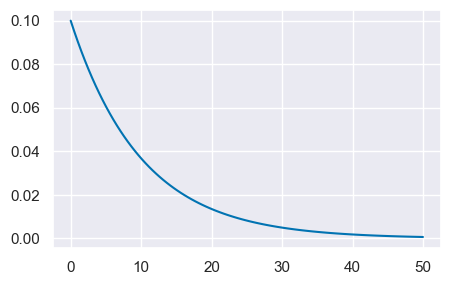

In [35]:
x = np.linspace (0, 50, 100) 
y = st.expon.pdf(x, 0, 10)
plt.plot(x, y)

In [36]:
r = st.expon.rvs(0, 10, size=100000)
r.mean()

10.012678392247345

Rappresentiamo ora la nostra credenza a priori utilizzando in un modello bayesiano utilizzando PyMC.

Consideriamo un singlo individuo di genere maschile appartenente a questa popolazione. Se, in media, in 6 mesi ci aspettiamo un numero di episodi di violenza pari a 11.46, possiamo descrivere il numero di episodi di violenza per un singolo individuo con la seguente distribuzione di Poisson.

In [81]:
l = 1/10

with pm.Model() as model:
    mu = pm.Exponential("mu", l)
    idata = pm.sample_prior_predictive(samples=2000, random_seed=rng)

Sampling: [mu]


Vediamo qui 2000 campioni casuali estratti dalla distribuzione a priori. Il risultato è simile alla distribuzione di densità teorica rappresentata nel grafico precedente.

<AxesSubplot: title={'center': 'mu'}>

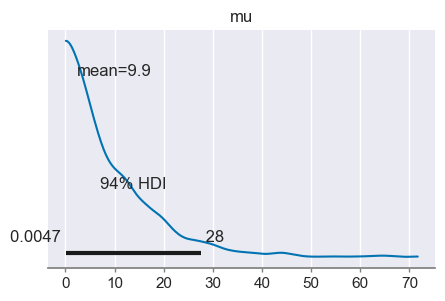

In [82]:
az.plot_posterior(idata.prior.mu)

Adesso inseriamo nel modello la verosimiglianza. La verosimiglianza di Poisson è simile a quella Binomiale, con la differenza che, nella Binomiale il numero di "successi" non può essere maggiore di $n$ (il numero di prove) mentre, nella distribuzione di Poisson non c'è un limite superiore. Consideriamo uno specifico paziente -- chiamiamolo Francesco.  Usando i 12 item della sottoscala relativa agli episodi di violenza fisica della *Conflict Tactics Scales-2* troviamo, per Mario, un numero di episodi violenti nei confronti del partner uguale a 4 (negli ultimi 6 mesi). Inseriamo dunque questa informazione nel modello bayesiano.

In [87]:
with pm.Model() as model:
    mu = pm.Exponential("mu", l)
    episodes = pm.Poisson("episodes", mu, observed=8)
    idata2 = pm.sample(2000)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


In [88]:
sample_posterior = idata2.posterior['mu']

<AxesSubplot: title={'center': 'mu'}>

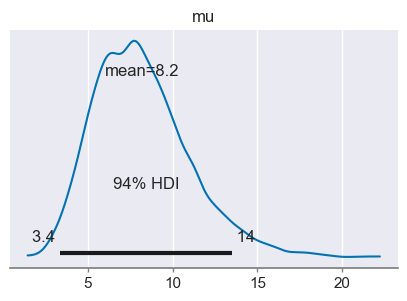

In [89]:
az.plot_posterior(sample_posterior)

In [94]:
with pm.Model() as model3:
    mu_A = pm.Exponential("mu_A", l)
    mu_B = pm.Exponential("mu_B", l)
    episodes_A = pm.Poisson("episodes_A", mu_A, observed=[8])
    episodes_B = pm.Poisson("episodes_B", mu_B, observed=[12])
    idata3 = pm.sample(2000)

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


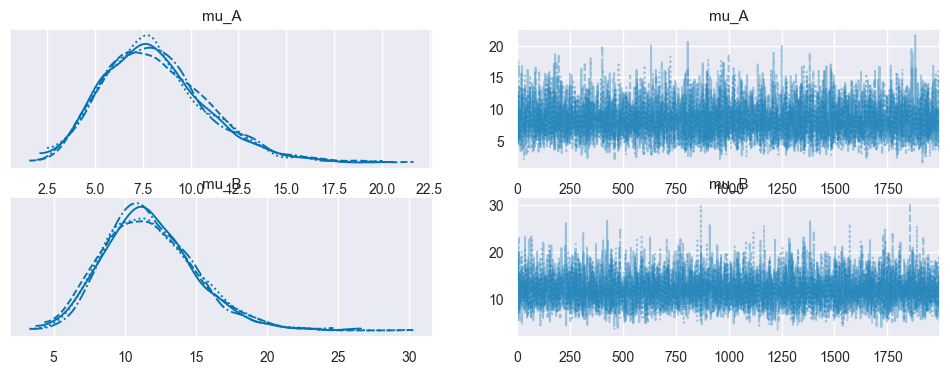

In [95]:
with model3:
    az.plot_trace(idata3)

In [99]:
mu_A = idata3.posterior['mu_A']
mu_B = idata3.posterior['mu_B']
mu_B.mean(), mu_A.mean()

(<xarray.DataArray 'mu_B' ()>
 array(11.76675263),
 <xarray.DataArray 'mu_A' ()>
 array(8.15179614))

In [100]:
def plot_kde(sample, **options):
    """Plot a distribution using KDE.
    
    sample: sequence of values
    """
    sns.kdeplot(sample, cut=0, **options)

<AxesSubplot: title={'center': 'mu_B'}>

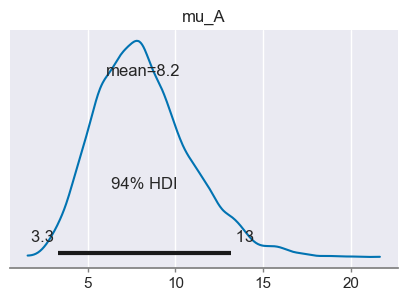

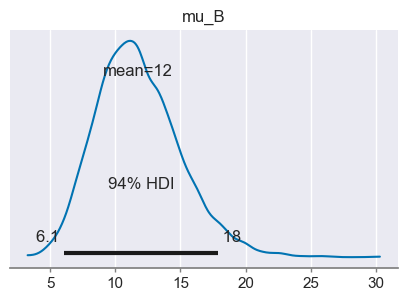

In [102]:
sample_post_A = idata3.posterior['mu_A']
sample_post_B = idata3.posterior['mu_B']
az.plot_posterior(sample_post_A)
az.plot_posterior(sample_post_B)

In [104]:
(mu_B > mu_A).mean()

<xarray.DataArray ()>
array(0.808875)

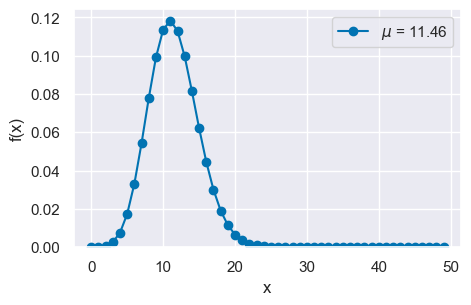

In [37]:
x = np.arange(0, 50)
m = 11.46
pmf = st.poisson.pmf(x, m)
plt.plot(x, pmf, '-o', label='$\mu$ = {}'.format(m))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0)
plt.legend(loc=1)
plt.show()

Sampling: [goals, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


In [77]:
sample_posterior = trace3.posterior['mu']
sample_posterior.mean()


<xarray.DataArray 'mu' ()>
array(2.72783086)

<AxesSubplot: title={'center': 'mu'}>

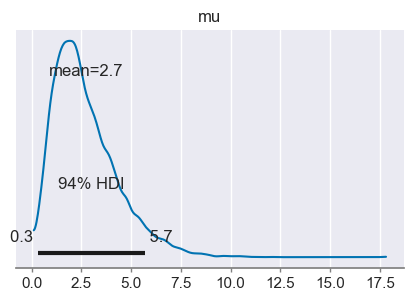

## La distribuzione predittiva a posteriori
Una volta costruita la distribuzione a posteriori del parametro o dei parametri sconosciuti, potremmo essere interessati a utilizzare il modello bayesiano allo scopo di prevedere la probabilità di risultati futuri basandoci sui dati già osservati. Questo tipo di analisi inferenziale va sotto il nome di *analisi predittiva*.

L'esempio che considereremo qui nei dettagli riguarda il caso beta-binomiale, nel quale la distribuzione a priori per il parametro ignoto $\theta$ (ovvero, la probabilità di successo) è una distribuzione Beta, la verosimiglianza è binomiale e i dati sono costituiti dal numero $y$ di successi in $n$ prove Bernoulliane indipendenti. Nell'esempio che discuteremo useremo un'altra volta i dati del campione di pazienti clinici depressi di {cite:t}`zetsche_2019future`. Supponendo di volere esaminare in futuro altri $m$ pazienti clinici, ci chiediamo: quanti di essi manifesteranno una depressione grave?

Siamo dunque interessati a predire i risultati che si potrebbero osservare in nuovi campioni di $m = 30$ osservazioni. Denotiamo con $\tilde{y}$ la manifestazione della variabile casuale $\tilde{Y}$. In un nuovo campione di $m$ osservazioni, $\tilde{y}$ assumerà il valore $\tilde{y}_1$ (ad es., 12), in un altro campione assumerà il valore $\tilde{y}_2$ (ad es., 23), e così via. Siamo interessati a descrivere la probabilità che $\tilde{y}$ assuma i valori $0, 1, 2, \dots, 29, 30$. Tale distribuzione (in questo caso) di massa di probabilità si chiama *distribuzione predittiva a posteriori* $p(\tilde{Y} = \tilde{y} \mid Y = y)$ e corrisponde alla probabilità assegnata a ciascuno dei possibili valori $\tilde{y}$ ($0, 1, 2, \dots, 29, 30$) nei possibili campioni futuri di $m$ osservazioni.

In questo Capitolo ci porremo il problema di trovare la distribuzione predittiva a posteriori nel caso beta-binomiale. Considereremo tre metodi diversi:

-   la soluzione analitica,
-   i risultati di una simulazione,
-   il campionamento MCMC.

I tre metodi producono risultati equivalenti. In seguito useremo il metodo MCMC perché ci consente di trovare facilmente la risposta cercata, anche quando una soluzione analitica non è disponibile.

## Soluzione analitica
Nel caso dell'esempio in discussione, la distribuzione di $\tilde{Y}$ dipende da $\theta$ e ciò che sappiamo di $\theta$ è sintetizzato nella distribuzione a posteriori $p(\theta \mid y)$. Usando la regola della catena, possiamo scrivere la distribuzione congiunta di $\tilde{y}$ e $\theta$ nel modo seguente

$$
p(\tilde{y}, \theta \mid y) = p(\tilde{y} \mid \theta, y) p(\theta \mid y).
$$

Assumendo che le osservazioni future $\tilde{y}$ e passate $y$ siano condizionalmente indipendenti dato $\theta$, l'espressione precedente può essere scritta come

$$
p(\tilde{y}, \theta \mid y) = p(\tilde{y} \mid \theta) p(\theta \mid y).
$$

La distribuzione predittiva a posteriori viene ottenuta dalla distribuzione congiunta di $\tilde{y}$ e $\theta$ integrando rispetto a $\theta$:

$$
p(\tilde{y} \mid y) = \int_{\theta} p(\tilde{y} \mid \theta) p(\theta \mid y) \,\operatorname {d}\!\theta.
$$ (eq-post-pred-distr)

Nel caso dello schema beta-binomiale, la funzione $p(\tilde{y} \mid \theta)$ è binomiale di parametri $m$ e $\theta$, e la distribuzione a posteriori $p(\theta \mid y)$ è una $Beta(\alpha + y, \beta + n - y)$. Risolvendo l'integrale otteniamo:

$$
\begin{align}
p(\tilde{y} \mid y) &= \int_0^1 p(\tilde{y} \mid \theta)
p(\theta \mid y)\,\operatorname {d}\!\theta \notag\\
 &= \int_0^1 \begin{pmatrix}m\\\tilde{y}\end{pmatrix}
 \theta^{\tilde{y}}
(1-\theta)^{m-\tilde{y}} \, Beta(a+y,b+n-y) \, d\theta \notag\\
&= \begin{pmatrix}{m}\\\tilde{y}\end{pmatrix} \int_0^1 \theta^{\tilde{y}}
(1-\theta)^{m-\tilde{y}} \frac{1}{B(a+y, b+n-y)}\theta^{a+y-1}(1-\theta)^{b+n-y-1}\notag\\
&= \begin{pmatrix}{ m }\\\tilde{y}\end{pmatrix} \frac{1}{B(a+y, b+n-y)}\int_0^1 \theta^{\tilde{y}+a+y-1}(1-\theta)^{m-\tilde{y}+b+n-y-1}\notag\\
&= \begin{pmatrix}{ m }\\\tilde{y}\end{pmatrix} \frac{B(\tilde{y}+a+y,b+n-y+m-\tilde{y})}{B(a+y, b+n-y)} \; .
\end{align}
$$ (eq-post-yprime-an-sol-betabin)

In conclusione, per lo schema beta-binomiale, la distribuzione predittiva a posteriori corrisponde ad una distribuzione di probabilità discreta chiamata *distribuzione beta-binomiale* di parametri $m$, $\alpha+y$ e $\beta+n-y$.

$$
f(\tilde{y} \mid y) = \binom{m}{\tilde{y}} \frac{B(a+ y + \tilde{y}, b + n - y + m - \tilde{y})}{B(a+y, b+n-y)},
$$ (eq-beta-binomial-distr)

Nell'esempio relativo allo studio di {cite:t}`zetsche_2019future`, la verosimiglianza è binomiale, i dati sono costituiti da 23 successi su 30 prove e la distribuzione a priori su $\theta$ è $(Beta)(2, 10)$. Di conseguenza, la distribuzione a posteriori è $Beta(25, 17)$. Vogliamo calcolare la distribuzione predittiva a posteriori per un nuovo campione, poniamo, di $m = 30$ osservazioni (ma, in generale, $m$ può essere diverso da $n$).

In base all'eq. {eq}`eq-beta-binomial-distr` sappiamo che la distribuzione predittiva a posteriori è una distribuzione beta-binomiale di parametri $m$, $\alpha+y$ e $\beta+n-y$, dove $m$ è il numero di prove nel nuovo campione, $\alpha$ e $\beta$ sono i parametri della distribuzione a priori, e $y$ e $n$ sono le proprietà del campione corrente. Nel caso dell'esempio in discussione, $m = 30$, $\alpha = 2 + 23 = 25$, $\beta = 10 + 30 - 23 = 17$. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import statistics
import arviz as az
import seaborn as sns
from scipy.stats import betabinom, beta, binom
import pymc as pm
import xarray as xr
from scipy.constants import golden
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline
plt.rc('figure', figsize=(5.0, 5.0/golden))
sns.set_theme()
sns.set_palette("colorblind")
SEED = 42
rng = np.random.default_rng(SEED)

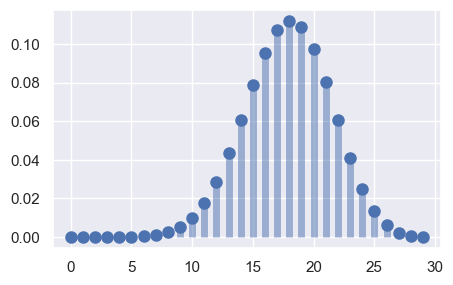

In [3]:
n = 30
a = 25
b = 17

x = np.arange(0, 30)
plt.plot(x, betabinom.pmf(x, n, a, b), "bo", ms=8, label="betabinom pmf")
plt.vlines(x, 0, betabinom.pmf(x, n, a, b), colors="b", lw=5, alpha=0.5)

La distribuzione predittiva a posteriori illustrata nella figura precedente ci dice qual è la credibilità relativa di osservare $0, 1, \dots, 30$ successi su $m = 30$ prove in un futuro campione di osservazioni, alla luce dei dati che abbiamo osservato nel campione corrente (23 successi in 30 prove) e tenuto conto delle nostre opinioni a priori sulla plausibilità dei possibili valori $\theta$ (ovvero, $Beta(2, 10)$).

Esaminando la distribuzione predittiva notiamo che, nei possibili campioni futuri di 30 osservazioni, il valore $\tilde{y}$ più plausibile è 18. Tuttavia, $\tilde{y}$ può assumere anche altri valori e la distribuzione predittiva ci informa sulla *credibilità relativa* di ciascuno dei possibili valori futuri $\tilde{y}$ -- nel presente esempio, $\tilde{y}$ corrisponde al numero di pazienti clinici (su 30) che manifestano una depressione grave.

È desiderabile costruire un intervallo che contiene le realizzazioni $\tilde{y}$ ad un livello specificato di probabilità. Supponiamo che il livello di probabilità richiesto sia 0.89. L'intervallo si costruisce aggiungendo valori $\tilde{y}$ all'intervallo (partendo da quello con la probabilità maggiore) fino a che il contenuto di probabilità dell'insieme eccede la soglia richiesta, nel caso presente di 0.89.

Sulla base delle informazioni disponibili, possiamo dunque prevedere, con un livello di certezza soggettiva che eccede la soglia di 0.91, che in un futuro campione di 30 soggetti clinici depressi, il numero di pazienti con depressione grave sarà compreso tra 12 e 23.

$$
P(12 \leq \tilde{y} \leq 23) = 0.9145.
$$

In [4]:
x_set = np.arange(12, 24)
betabinom.pmf(x_set, n, a, b).sum()

0.9152884954868495

In conclusione, per il caso beta-binomiale, possiamo dire che la predizione bayesiana di una nuova osservazione futura è la realizzazione di una distribuzione beta-binomiale di parametri $m$, $\alpha + y$, e $\beta + n - y$, dove $m$ è il numero di prove nel nuovo campione, $\alpha$ e $\beta$ sono i parametri della distribuzione a priori, e $y$ e $n$ sono le caratteristiche del campione.

## La distribuzione predittiva a posteriori mediante simulazione

In situazioni dove è difficile derivare l'esatta distribuzione predittiva a posteriori è comunque possibile ottenere un campione casuale di valori della distribuzione predittiva posteriori mediante simulazione. Facciamo un esempio riferito al caso che stiamo discutendo. È possibile svolgere la simulazione richiesta in due fasi. Supponiamo di volere ottenere un campione casuale di $n$ osservazioni dalla distribuzione predittiva a posteriori. A tal fine dobbiamo (1) estrarre $n$ valori a caso del parametro $\theta$ dalla distribuzione a posteriori $p(\theta \mid y)$: (2) con tali valori del parametro $\theta$ generiamo $n$ valori casuali $\tilde{y}$; a tal fine usiamo il modello binomiale di parametri $m$ e $\theta_i$ (con $i = 1, \dots, n$). Otteniamo così $n$ realizzazioni casuali di $n$ distribuzioni binomiali aventi i parametri specificati sopra.

Vediamo come si fa in pratica. Per l'esempio che stiamo discutendo, la distribuzione a posteriori è una $Beta(25, 17)$. Estraiamo 100,000 valori a caso da tale distribuzione e ne stampiamo i primi 10:

In [5]:
nrep = 100000
theta = beta.rvs(a, b, size=nrep)
print(*theta[0:10])

0.7413496242562254 0.5834826613847893 0.5572030235521689 0.6368930595734968 0.5749644043525947 0.5487254719095255 0.5967839997763181 0.5895976707419692 0.5766730497790263 0.636654787480037


Per ciascuno di questi 100,000 valori $\theta$ estraggo a caso un valore dalla distribuzione binomiale di parametri $n = 30$ e probabilità $\theta$. Stampo qui di seguito i primi 10 valori così trovati.

In [6]:
pred_y_sim = [binom.rvs(n=30, p=th, size=1) for th in theta]
pred_y_sim = np.concatenate(pred_y_sim)
print(*pred_y_sim[0:10])

24 14 15 18 18 21 15 16 19 16


L'insieme dei valori `pred_y_sim` costituisce un campione casuale dalla distribuzione predittiva a posteriori. Qui di seguito è mostrata una figura che riporta i risultati della simulazione (l'istogramma dei valori `pred_y_sim`). All'istogramma sono sovrapposti i punti della corretta distribuzione a posteriori corrispondente ad una distribuzione Beta-Binomiale di parametri n = 30, a = 25, b = 17. Si noti la corrispondenza tra i valori ottenuti e i valori teorici.

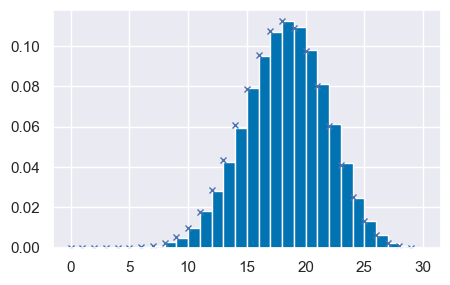

In [9]:
counts = plt.hist(pred_y_sim, bins=np.arange(0, 31), density=True)
_ = plt.plot(x, betabinom.pmf(x, n, a, b), "bx", ms=4, label="betabinom pmf")

## La distribuzione predittiva a posteriori mediante MCMC

Il metodo basato su simulazione che abbiamo discusso sopra si basa sulla stessa logica che i metodi MCMC usano per ottenere un'approssimazione della distribuzione predittiva a posteriori. Mediante i metodi MCMC, le stime delle possibili osservazioni future $p(\tilde{y} \mid y)$, chiamate $p(y^{rep} \mid y)$, si ottengono nel modo seguente:

-   campionare $\theta_i \sim p(\theta \mid y)$, ovvero scegliere un valore a caso del parametro dalla distribuzione a posteriori;
-   campionare $y^{rep} \sim p(y^{rep} \mid \theta_i)$, ovvero scegliere un'osservazione a caso dalla funzione di verosimiglianza condizionata al valore del parametro definito nel passo precedente.

Se i due passaggi descritti sopra vengono ripetuti un numero sufficiente di volte, l'istogramma risultante approssimerà la distribuzione predittiva a posteriori che, in alcuni casi, può essere ottenuta per via analitica (come nell'esempio presente).

### Posterior predictive checks

La distribuzione predittiva a posteriori viene utilizzata per eseguire i cosiddetti *controlli predittivi a posteriori* (*Posterior Predictive Checks*, PPC). Nella distribuzione predittiva a posteriori, viene generato un campione di dati possibili futuri utilizzando le proprietà del modello adattato. È ovvio che tali dati possibili futuri devono almento essere coerenti con i dati del campione presente. I PPC eseguono un confronto grafico tra $p(y^{rep} \mid y)$ e i dati osservati $y$: confrontando visivamente gli aspetti chiave dei dati previsti futuri $y^{rep}$ e dei dati osservati $y$ è possibile determinare se il modello è adeguato.

Oltre al confronto visivo tra le distribuzioni $p(y)$ e $p(y^{rep})$ è anche possibile un confronto tra la distribuzione di varie statistiche descrittive, i cui valori sono calcolati su diversi campioni $y^{rep}$, e le corrispondenti statistiche calcolate sui dati osservati. Vengono solitamente considerate statistiche descrittive quali la media, la varianza, la deviazione standard, il minimo o il massimo, ma sono possibili confronti di questo tipo per qualunque altra statistica.

In [26]:
ntrials = 30
y = 23

alpha_prior = 2
beta_prior = 10

with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)
    idata = pm.sample(2000)

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


<AxesSubplot: title={'center': 'theta'}>

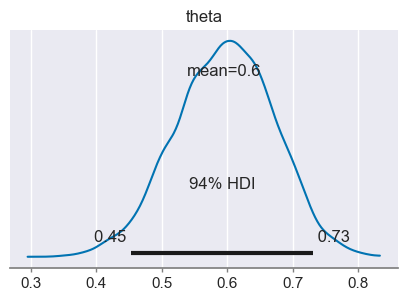

In [27]:
az.plot_posterior(idata.posterior.theta)

In [28]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

In [29]:
post_pred.posterior_predictive.obs

<xarray.DataArray 'obs' (chain: 4, draw: 2000)>
array([[20, 17, 12, ..., 16,  9, 14],
       [18, 10, 16, ..., 14, 11, 14],
       [18, 22, 16, ..., 17, 25, 24],
       [15, 18, 17, ..., 21, 20, 19]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

<AxesSubplot: title={'center': 'obs'}>

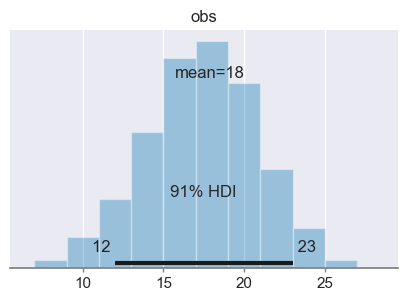

In [33]:
az.plot_posterior(post_pred.posterior_predictive.obs, hdi_prob=0.91)

## Distribuzione predittiva a priori

Nella sezione precedente abbiamo visto come la distribuzione predittiva viene usata per generare nuovi dati previsti futuri. Più precisamente, mediante l'eq. {eq}`eq-post-pred-distr` abbiamo descritto la nostra incertezza sulla distribuzione di future osservazioni di dati, data la distribuzione a posteriori di $\theta$, ovvero tenendo conto della scelta del modello e della stima dei parametri mediante i dati osservati.

$$
p(\tilde{y} \mid y) = \int_{\theta} p(\tilde{y} \mid \theta) p(\theta \mid y) \,\operatorname {d}\!\theta\notag
$$

Si noti che, nell'eq. {eq}`eq-post-pred-distr`, $\tilde{y}$ è condizionato da $y$ ma non da ciò che è incognito, ovvero $\theta$. La distribuzione predittiva a posteriori è ottenuta mediante marginalizzazione sopra i parametri incogniti $\theta$.

In un modello bayesiano dove $\theta$ ha una distribuzione a priori $p(\theta)$ e per $y$ possiamo definire la funzione di verosimiglianza $p(y \mid \theta)$ possiamo scrivere la distribuzione congiunta $p(y, \theta)$ come il prodotto della verosimiglianza e della distribuzione a priori:

$$
p(y, \theta) = p(y \mid \theta)p(\theta).
$$

Una rappresentazione alternativa della distribuzione congiunta $p(y, \theta)$ è

$$
p(y, \theta) = p(\theta \mid y)p(y).
$$

Il primo termine in questo prodotto, la densità $p(\theta \mid y)$, è la densità a posteriori di $\theta$ date le osservazioni $y$. Il secondo termine in questo prodotto, $p(y)$, è la *distribuzione predittiva a priori* che rappresenta la distribuzione dei dati futuri previsti dal modello prima di avere osservato il campione $y$. Se risulta che i dati osservati $y$ non sono coerenti con la distribuzione predittiva a priori, ciò significa che il modello bayesiano non è specificato correttamente. In altre parole, questo ci dice che, in base al modello bayesiano che abbiamo formulato, è improbabile che si verifichino i dati che sono stati effettivamente osservati. Ovviamente, questo vuol dire che il modello è inadeguato.

La distribuzione predittiva a priori può essere ricavata facilmente se l'inferenza bayesiana viene svolta mediante i metodi MCMC. Anche la distribuzione predittiva a priori viene usata per verificare l'adeguatezza della formulazione del modello.

Nella discussione dell'analisi dei dati di {cite}`zetsche_2019future`, la $Beta(2, 10)$ è stata utilizzata quale distribuzione a priori solo per evidenziare le proprietà dell'aggiornamento bayesiano (ovvero, la differenza tra distribuzione a priori e distribuzione a posteriori). Se calcoliamo la distribuzione predittiva a priori ci rendiamo facilmente conto che la $Beta(2, 10)$ non è una buona scelta per i dati considerati. 

Per svolgere l'analisi predittiva a priori, usiamo la funzione `pm.sample_prior_predictive()`.

In [4]:
ntrials = 16
y = 14

alpha_prior = 2
beta_prior = 10

with pm.Model() as model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)
    idata = pm.sample_prior_predictive(samples=2000, random_seed=rng)

Sampling: [obs, theta]


In [9]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

I dati (sulla scala delle osservazioni $y$) sono contenuti in `idata.prior_predictive.obs`. Uso `arviz` per generare un istogramma:

<AxesSubplot: title={'center': 'obs'}>

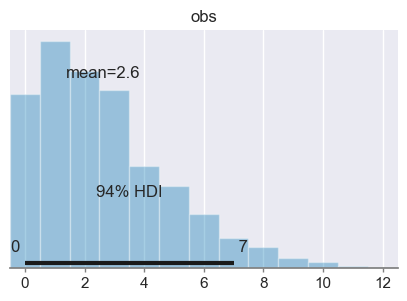

In [8]:
az.plot_posterior(idata.prior_predictive.obs)

La regione HDI al 94% è [0, 7]. Ma noi abbiamo osservato $y$ = 23. Dunque è chiaro che Beta(2, 10) non è una distribuzione a priori adeguata per i nostri dati.

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w